## Transverse field Ising model to demo primitives

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate

In [3]:
import numpy as np

In [4]:
SYGate = UnitaryGate(YGate().power(1/2),label = r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(),label = r"$\sqrt{Y}^\dag$")


def generate_1D_tfin_im(num_qubits,num_trotter_steps, rx_angle, num_cl_bits = 0, trotter_barriers = False, layer_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    for trotter_step in range(num_trotter_steps):
        add_1D_tfin_trotter_layer(qc,rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_1D_tfin_trotter_layer(qc,rx_angle,layer_barriers = False):
    #Adding Rzz in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.sdg([i,i+1])
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
    if layer_barriers:
        qc.barrier()
    #Adding Rzz in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.sdg([i,i+1])
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
    if layer_barriers:
        qc.barrier()

    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
        
    

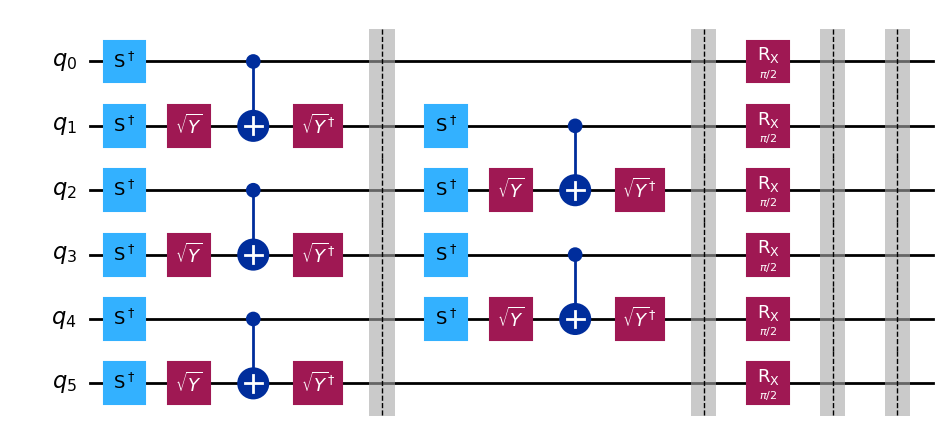

In [5]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5*np.pi

qc = generate_1D_tfin_im(num_qubits,num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
qc.draw(output = "mpl")

In [6]:
def add_miirored_1D_tfin_im(qc, num_qubits,num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):
    for trotter_step in range(num_trotter_steps):
        add_mirrored_1D_tfin_trotter_layer(qc,rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

def add_mirrored_1D_tfin_trotter_layer(qc,rx_angle,layer_barriers = False):
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
    #Adding Rzz in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
        qc.s([i,i+1])
    if layer_barriers:
        qc.barrier()
    #Adding Rzz in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
        qc.s([i,i+1])
    if layer_barriers:
        qc.barrier()

add_miirored_1D_tfin_im(qc, num_qubits,num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
    

  

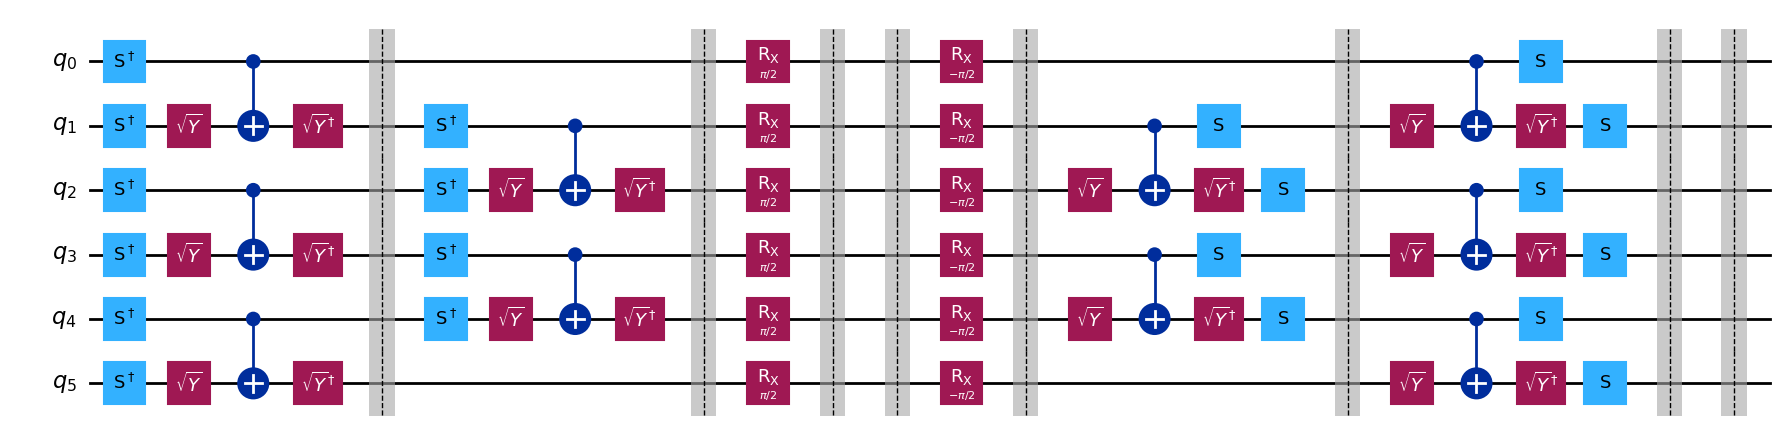

In [7]:
qc.draw(output = "mpl",fold = -1)

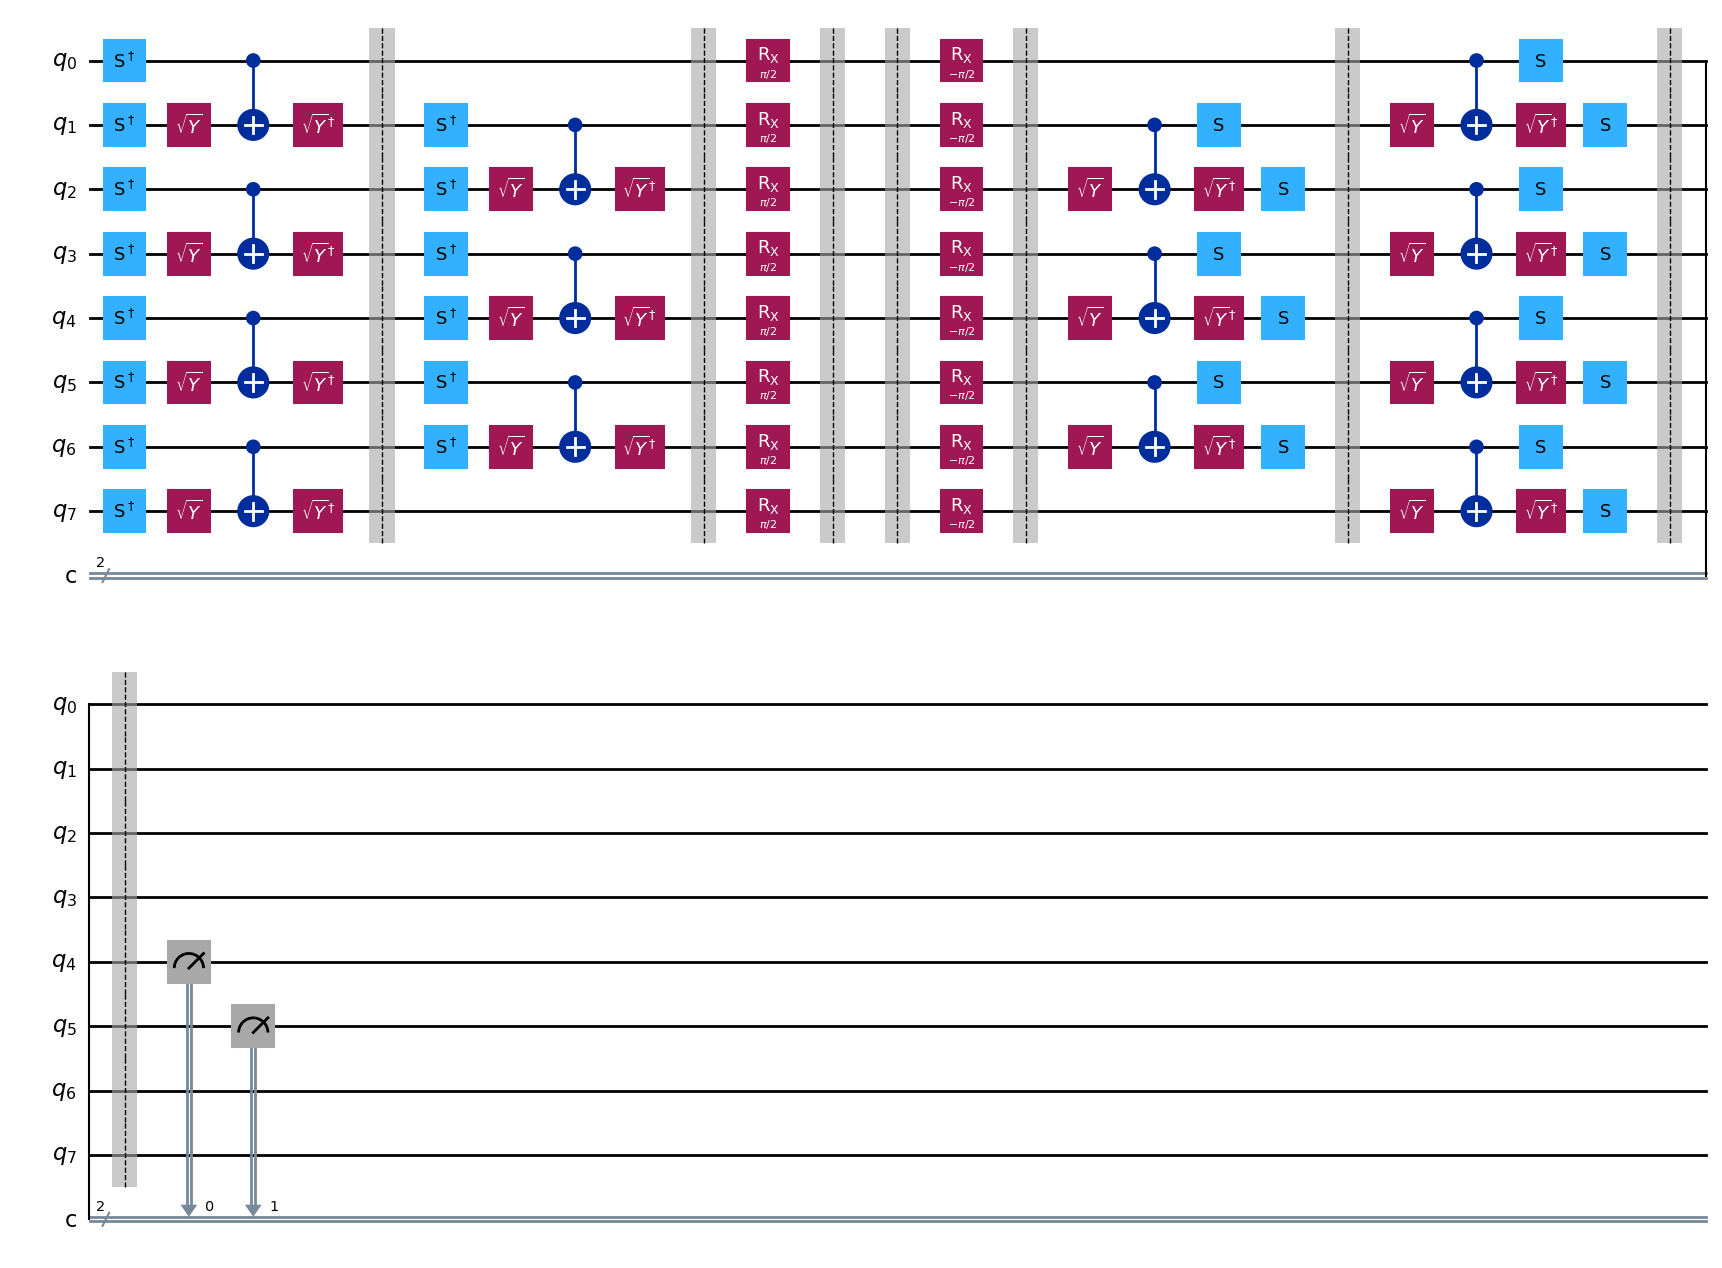

In [8]:
max_trotter_steps = 10
num_qubits = 8
measured_bits =[4,5]

qc_list = []
for trotter_steps in range(max_trotter_steps):
    qc = generate_1D_tfin_im(num_qubits,trotter_steps, rx_angle, num_cl_bits = len(measured_bits), trotter_barriers = True, layer_barriers = True)
    add_miirored_1D_tfin_im(qc, num_qubits,trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
    qc.measure(measured_bits,list(range(len(measured_bits))))
    qc_list.append(qc)

qc_list[1].draw(output = "mpl")
    
    
    

In [9]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)
print('Done getting backend')


qc_transpiled_list = transpile(qc_list,backend = backend, optimization_level = 1)

Done getting backend


In [10]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = 'XY4'

job = sampler.run(qc_transpiled_list)
print(job.job_id())

cs14q3c75q40008tmb5g


In [11]:
job_id = 'cs09sbdkfpw00080b96g'
job = service.job(job_id)

survival_probability_list = []
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0'*len(measured_bits)]/data.c.num_shots)
    except:
        survival_probability_list.append(0)
    

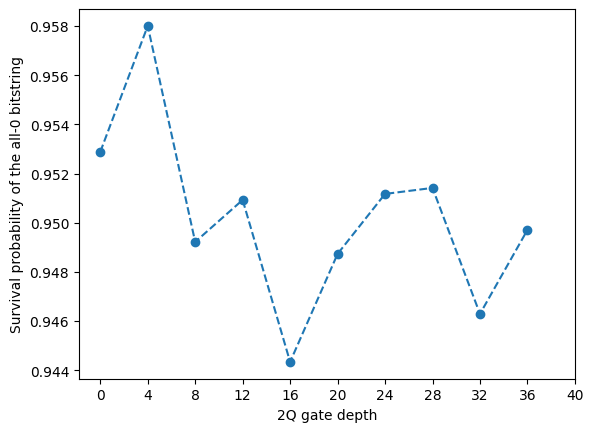

In [12]:
import matplotlib.pyplot as plt

plt.plot(list(range(0,4*max_trotter_steps,4)),survival_probability_list,'--o')
plt.xlabel('2Q gate depth')
plt.ylabel('Survival probability of the all-0 bitstring')
plt.xticks(np.arange(0,44,4))
plt.show()

In [13]:
from qiskit.circuit import Parameter
rx_angle = Parameter('rx_angle')
num_trotter_steps = 2
qc = generate_1D_tfin_im(num_qubits,num_trotter_steps, rx_angle)

from qiskit.quantum_info import SparsePauliOp

middle_index = num_qubits //2
observable = SparsePauliOp('I'*middle_index + 'Z' + 'I'*(middle_index-1))

In [14]:
qc_transpiled = transpile(qc, backend=backend,optimization_level = 1)
observable =observable.apply_layout(qc_transpiled.layout)

In [15]:
from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

min_rx_angle = 0
max_rx_angle = np.pi/2
num_rx_angle = 12

rx_angle_list = np.linspace(min_rx_angle,max_rx_angle,num_rx_angle)
options = EstimatorOptions()

options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = 'XY4'

estimator = EstimatorV2(backend = backend,options = options)
job = estimator.run([(qc_transpiled, observable, rx_angle_list)])

print(job.job_id())

cs14q4m75q40008tmb60


## Coding the fsim gates, we create a function to add such gates

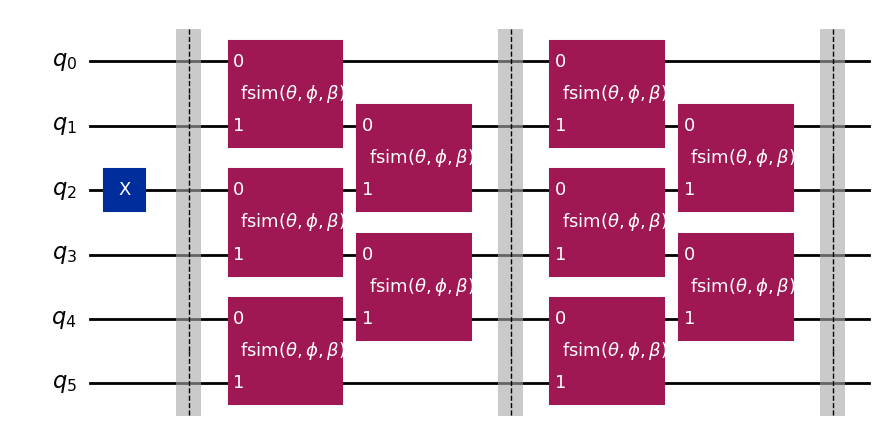

In [16]:
from qiskit.quantum_info import Operator
import math as m
import cmath as cm

def fsim(theta,phi,beta):
    fsim = Operator([[1,0,0,0],
                   [0,m.cos(theta),1j*cm.exp(1j*beta)*m.sin(theta),0],
                   [0,1j*cm.exp(-1j*beta)*m.sin(theta),m.cos(theta),0],
                   [0,0,0,cm.exp(1j*phi)]])
    return fsim

def circuit(num_qubits, pos1, trotter_steps,angles = [0,0,0], num_cl_bits = 0, trotter_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    qc.x(pos1-1)
    qc.barrier()
    for trotter_step in range(trotter_steps):
        add_fsim(qc,angles)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_fsim(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi,\beta)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi,\beta)$')


num_qubits = 6
trotter_steps = 2
pos1 = 3
angles = [np.pi/4,0,0]
qc = circuit(num_qubits,pos1,trotter_steps,angles,trotter_barriers = True)
qc.draw(output = 'mpl')
    

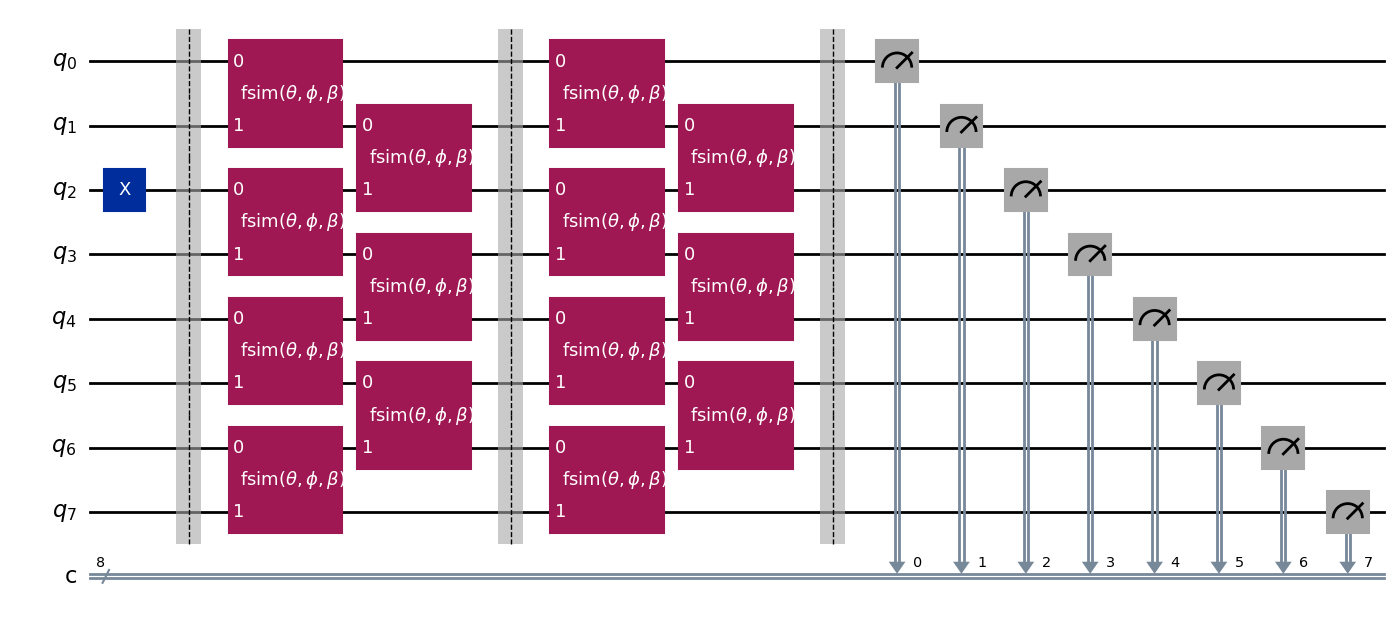

In [17]:
max_trotter_steps = 10
num_qubits = 8
measured_bits =[0,1,2,3,4,5,6,7]

qc_list = []
for trotter_steps in range(max_trotter_steps):
    qc = circuit(num_qubits,pos1, trotter_steps, angles, num_cl_bits = len(measured_bits), trotter_barriers = True)
    qc.measure(measured_bits,list(range(len(measured_bits))))
    qc_list.append(qc)

qc_list[2].draw(output = "mpl")

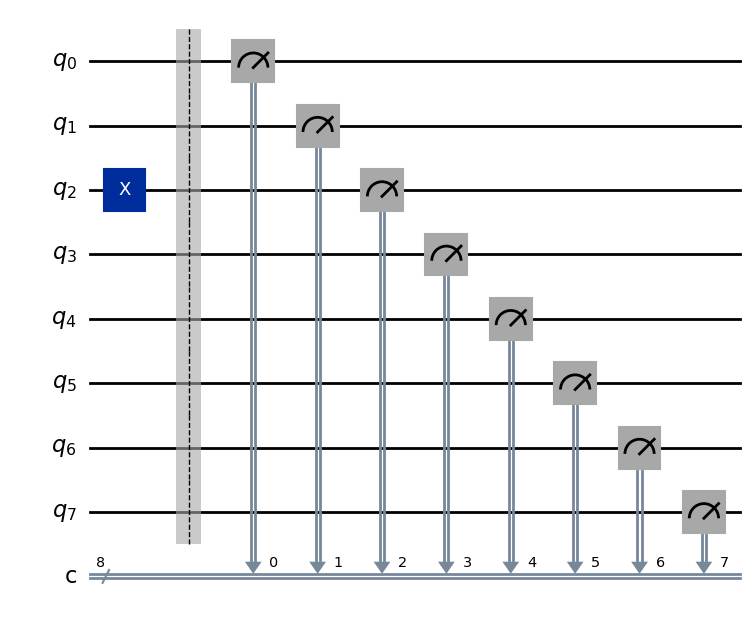

In [18]:
qc_list[0].draw(output = "mpl")

In [19]:
qc_transpiled_list = transpile(qc_list,backend = backend, optimization_level = 1)

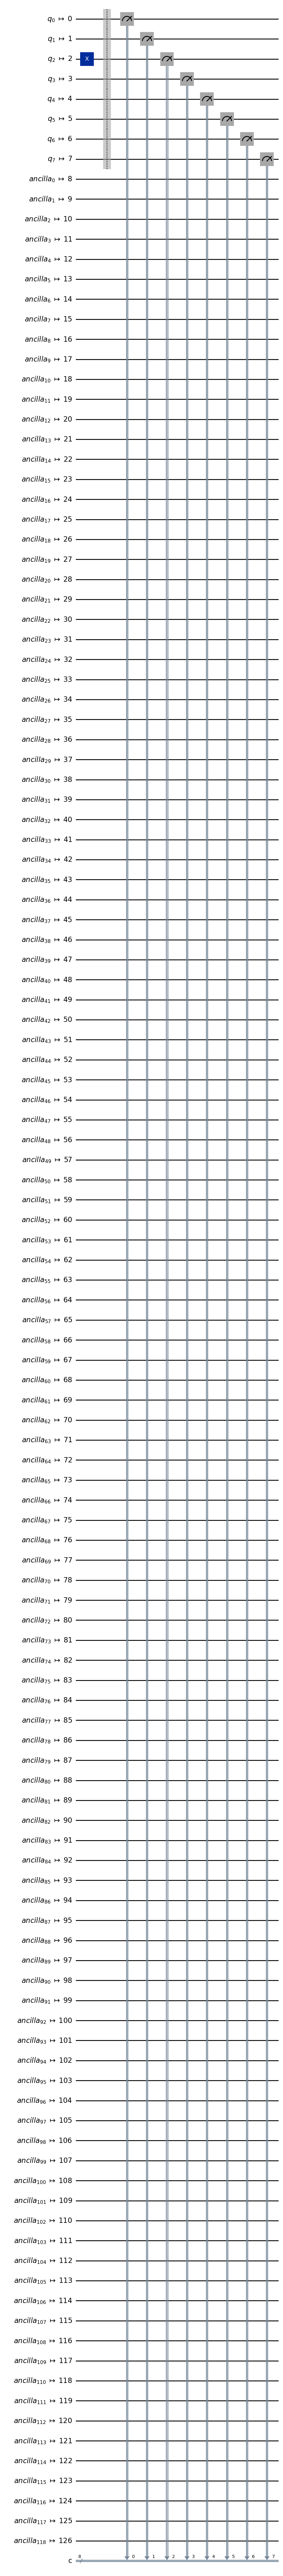

In [20]:
qc_transpiled_list[0].draw(output = "mpl")

In [21]:
job = sampler.run(qc_transpiled_list)
print(job.job_id())

cs14qadyhpyg008agn00


In [22]:
def required_bitsrings(num_qubits):
    bitstring_list = ['0'*i +'1' + '0'*(num_qubits-i-1) for i in range(num_qubits)]
    return bitstring_list

string_list = required_bitsrings(num_qubits)
for i in range(len(string_list)):
    string_list[i] = string_list[i][::-1]
print(string_list)


['00000001', '00000010', '00000100', '00001000', '00010000', '00100000', '01000000', '10000000']


[0.00146484375, 0.0009765625, 0.8212890625, 0.001220703125, 0, 0, 0.000732421875, 0.000244140625]
[0.004150390625, 0.00537109375, 0.002685546875, 0.022705078125, 0.6572265625, 0.00244140625, 0.000732421875, 0.00048828125]
[0.007080078125, 0.03271484375, 0.004150390625, 0.0078125, 0.003173828125, 0.001953125, 0.514892578125, 0.003662109375]
[0.02734375, 0.005615234375, 0.009765625, 0.005615234375, 0.005615234375, 0.004638671875, 0.00537109375, 0.40869140625]
[0.00341796875, 0.003662109375, 0.025390625, 0.005859375, 0.01123046875, 0.31103515625, 0.0107421875, 0.006591796875]
[0.0048828125, 0.004150390625, 0.0048828125, 0.28466796875, 0.01123046875, 0.00537109375, 0.0107421875, 0.005859375]
[0.002685546875, 0.23193359375, 0.005615234375, 0.00390625, 0.00732421875, 0.005859375, 0.009521484375, 0.00927734375]
[0.21728515625, 0.0078125, 0.010009765625, 0.003662109375, 0.007080078125, 0.0078125, 0.00537109375, 0.0087890625]
[0.010009765625, 0.00830078125, 0.147216796875, 0.009521484375, 0.011

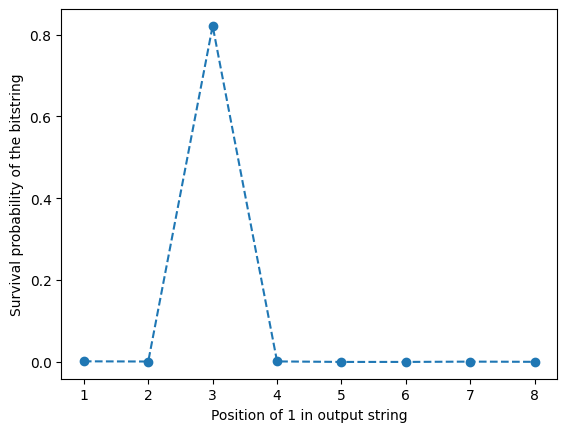

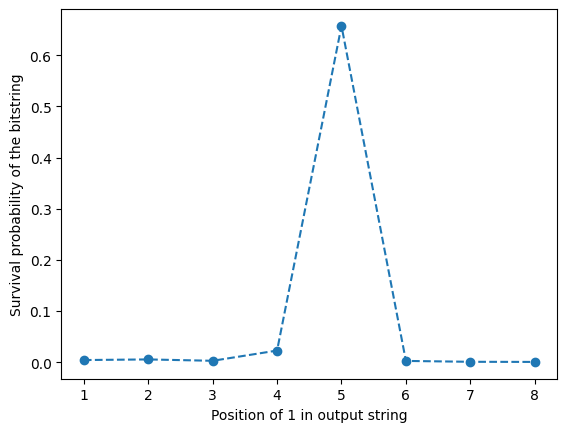

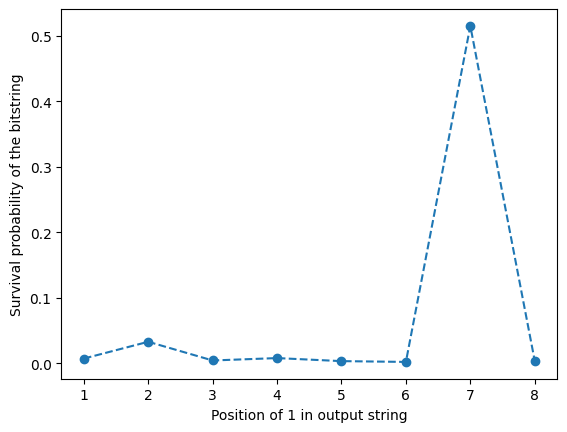

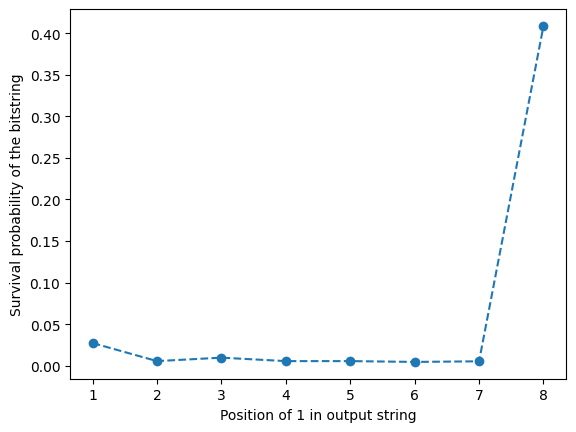

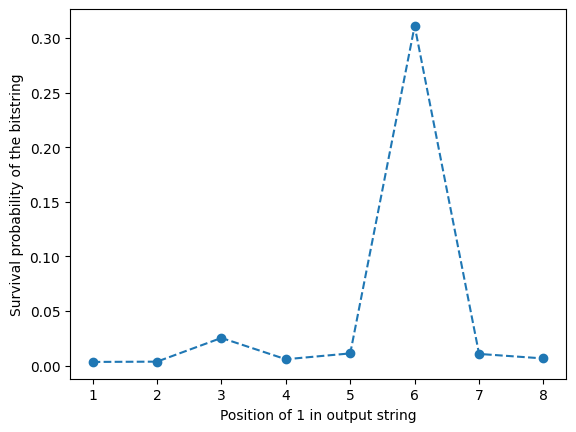

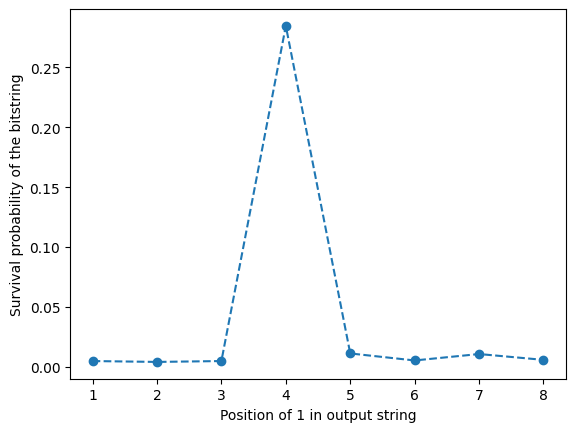

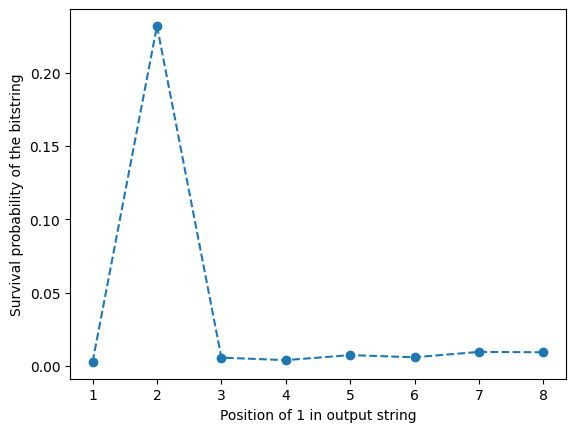

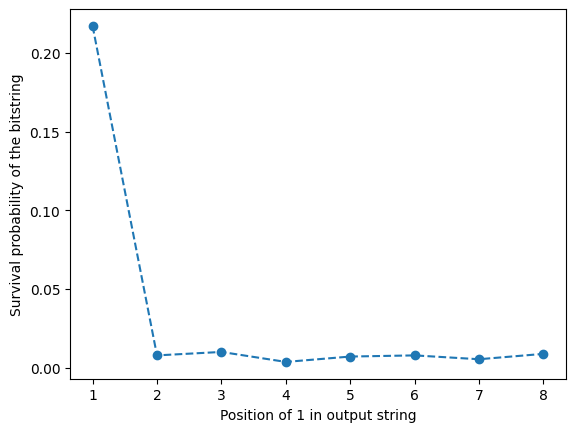

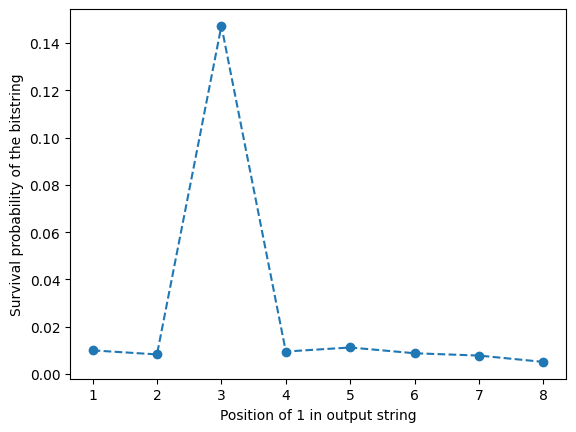

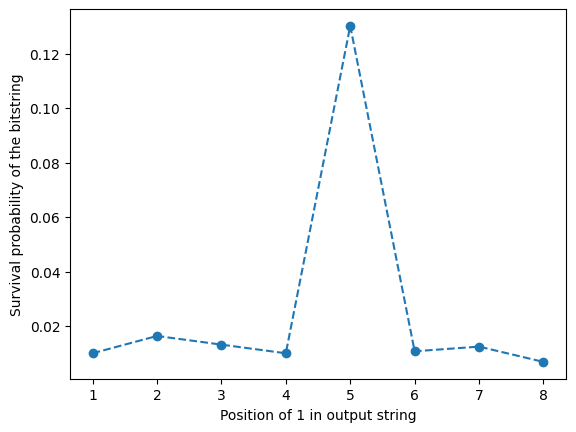

In [23]:
job_id = 'cs0g0a1965y00084z3kg'
job = service.job(job_id)

string_distribution_list = []
for trotter_step in range(max_trotter_steps):
    data = job.result()[trotter_step].data
    list1 = []
    for i in string_list:
        try:
            list1.append(data.c.get_counts()[i]/data.c.num_shots)
        except:
            list1.append(0)
    print(list1)
    string_distribution_list.append(list1)

            
for trotter_step in range(max_trotter_steps):
    plt.plot(list(range(1,num_qubits+1)),string_distribution_list[trotter_step],'--o')
    plt.xlabel('Position of 1 in output string')
    plt.ylabel('Survival probability of the bitstring')
    plt.xticks(np.arange(1,9))
    plt.show()

[{4: 1.0}, {16: 0.25, 2: 0.25, 4: 0.25, 8: 0.25}, {1: 0.125, 16: 0.5625, 2: 0.0625, 32: 0.0625, 4: 0.0625, 64: 0.0625, 8: 0.0625}, {1: 0.182138347648319, 16: 0.0625, 2: 0.091069173824159, 32: 0.140625, 4: 0.039292478527522, 64: 0.390625, 8: 0.0625, 128: 0.03125}, {1: 0.0078125, 16: 0.082146239263761, 2: 0.114506673824159, 32: 0.0078125, 4: 0.152228760736239, 64: 0.287952065439602, 8: 0.026118326175841, 128: 0.321422934560398}, {1: 0.03125, 16: 0.005361652351682, 2: 0.00390625, 32: 0.007047033230885, 4: 0.239391684560398, 64: 0.01305916308792, 8: 0.091069173824159, 128: 0.608915042944956}, {1: 0.00652958154396, 16: 0.160711467280199, 2: 0.04553458691208, 32: 0.135953283230886, 4: 0.00067020654396, 64: 0.276558554192279, 8: 0.152228760736239, 128: 0.221813559560398}, {1: 0.0087890625, 16: 0.039292478527522, 2: 0.003712417177896, 32: 0.780100530483374, 4: 0.126112900690224, 64: 0.012910917369552, 8: 0.027573728527522, 128: 0.00150796472391}, {1: 0.000538589052896, 16: 0.191003999137329, 2

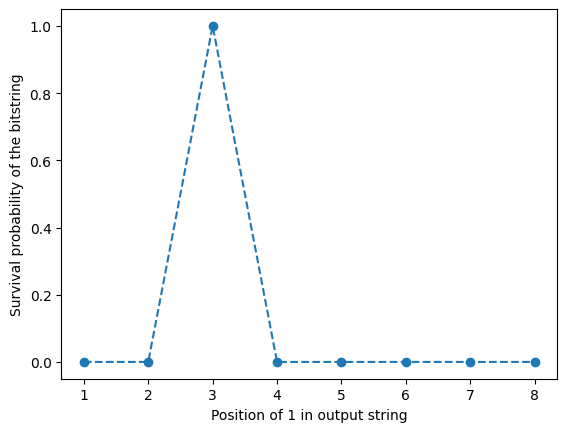

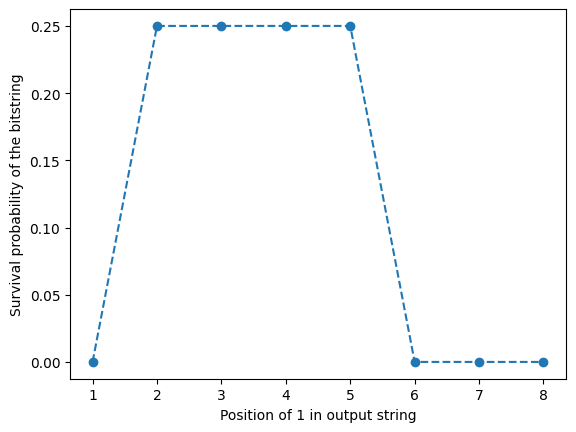

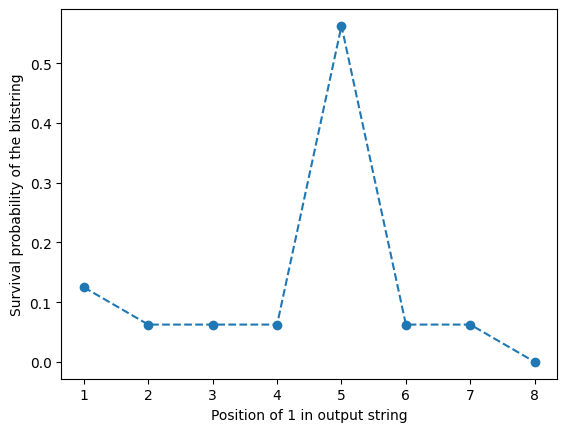

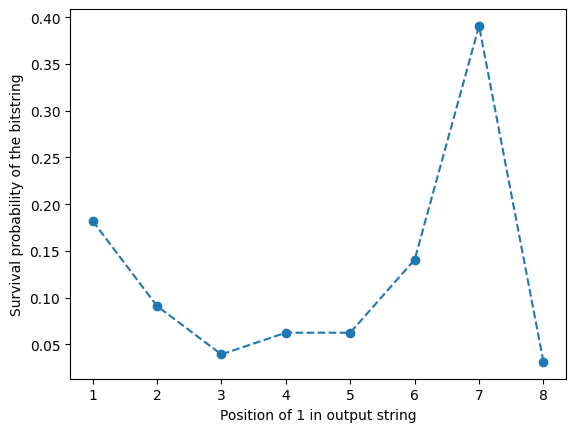

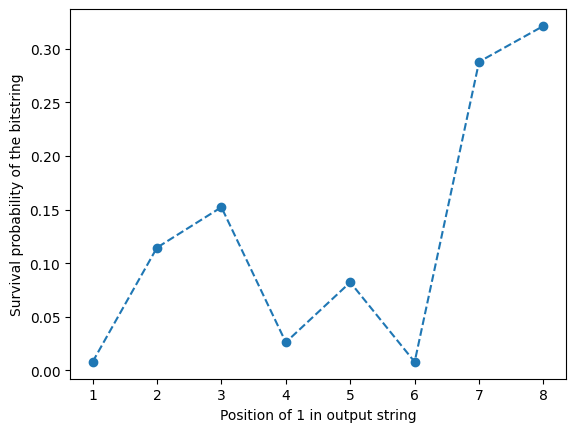

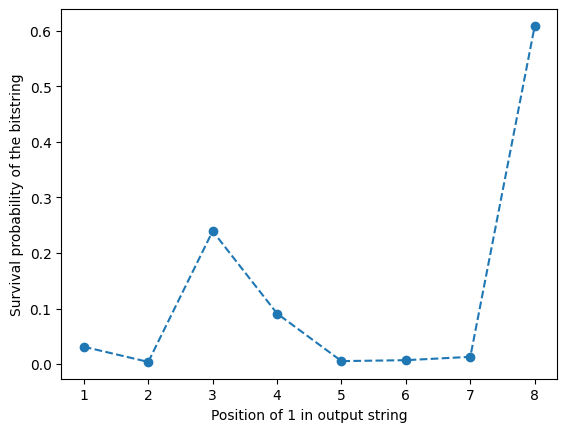

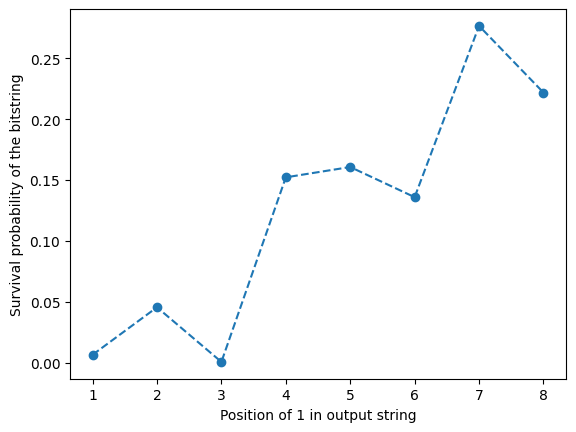

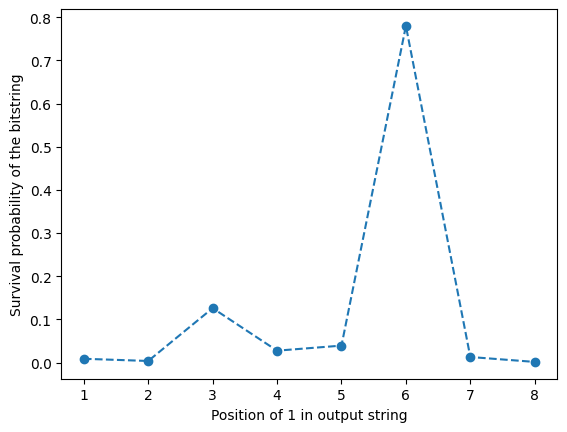

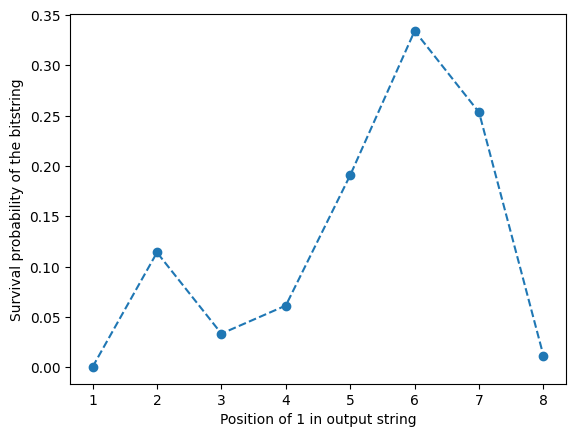

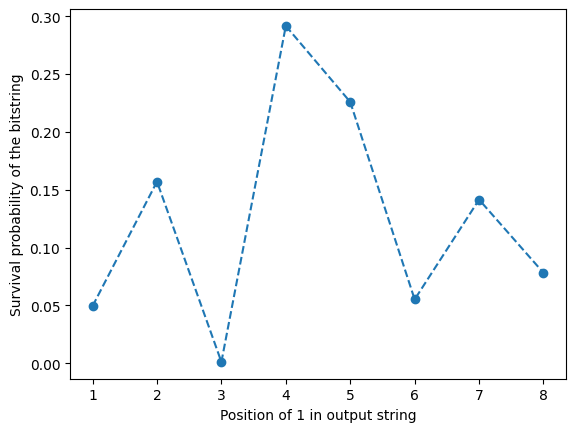

In [24]:
from qiskit_aer.primitives import Sampler

sampler = Sampler()
job = sampler.run(qc_list,shots = None)
exact_quasis = job.result().quasi_dists
print(exact_quasis)

sim_distribution_list = []
for trotter_step in range(max_trotter_steps):
    data = job.result().quasi_dists[trotter_step]
    list1 = []
    for i in string_list:
        num = int(i,2)
        try:
            list1.append(data[num])
        except:
            list1.append(0)
        
    print(list1)
    sim_distribution_list.append(list1)


for trotter_step in range(max_trotter_steps):
    plt.plot(list(range(1,num_qubits+1)),sim_distribution_list[trotter_step],'--o')
    plt.xlabel('Position of 1 in output string')
    plt.ylabel('Survival probability of the bitstring')
    plt.xticks(np.arange(1,9))
    plt.show()

## Calculating the band structure for a ring arrangement